In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

from modules import Net, AWNGChannel, BSChannel, RepeatEncoder, RepeatDecoder

R = 5
n_batches = 100
batch_size = 128
n_bits = 64
code_len = R*64

def model_accuracy(encoder, decoder, channel):
    all_data = (torch.rand((1000, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0
    for data in all_data:
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        #corrupted.data[corrupted.data > 0] = 1
        #corrupted.data[corrupted.data < 0] = -1
        reconstruction = decoder(corrupted) 
        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
    return float(n_correct) / all_data.nelement()

# Overfitting
Train data is generated once in the beginning of training process

89.2694091797


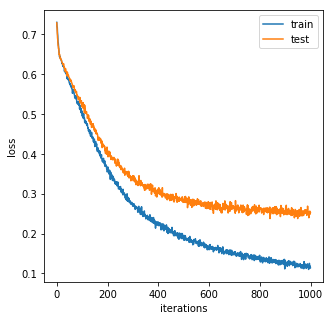

In [12]:
mid_dim = 1024
encoder = Net(n_bits, mid_dim, code_len, 2, 'all', True).cuda()
decoder = Net(code_len, mid_dim, n_bits, 2, 'all', False).cuda()
channel = AWNGChannel(1.0).cuda()
params = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

n_correct = 0
optimizer = optim.SGD(params, lr=1.0, momentum=0.9, weight_decay=0.0)

train_losses = []
test_losses = []

n_batches = 10

train_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
test_data  = (torch.rand((batch_size, n_bits)) > 0.5).type(torch.FloatTensor)

for i in range(100):
    #train_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    for data in train_data:
        optimizer.zero_grad()
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
        train_losses.append(loss.data[0])
        
        data = Variable(test_data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        test_losses.append(loss.data[0])
    
print float(n_correct) / train_data.nelement()

plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('iterations')
plt.savefig('overfitting.png', dpi=120)

# No Overfitting
New training data is generated on every step

85.3522827148


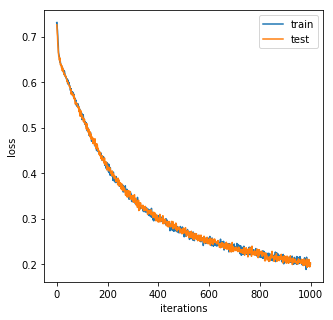

In [13]:
mid_dim = 1024
encoder = Net(n_bits, mid_dim, code_len, 2, 'all', True).cuda()
decoder = Net(code_len, mid_dim, n_bits, 2, 'all', False).cuda()
channel = AWNGChannel(1.0).cuda()
params = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

n_correct = 0
optimizer = optim.SGD(params, lr=1.0, momentum=0.9, weight_decay=0.0)

train_losses = []
test_losses = []

n_batches = 10
#train_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
test_data  = (torch.rand((batch_size, n_bits)) > 0.5).type(torch.FloatTensor)

for i in range(100):
    train_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    for data in train_data:
        optimizer.zero_grad()
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
        train_losses.append(loss.data[0])
        
        data = Variable(test_data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        test_losses.append(loss.data[0])
    
print float(n_correct) / train_data.nelement()

plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('iterations')
plt.savefig('no_overfitting.png', dpi=120)